In [49]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tools.plotting import autocorrelation_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import operator

In [50]:
%matplotlib inline

In [51]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [52]:
def readFile(filename):
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y')
    df_1 = pd.read_csv(filename, header=0,parse_dates=[0],index_col=0,date_parser=dateparse)
    print("File read into dataframe.")
    print(df_1.shape)
    df_1 = df_1.sort()
    return df_1

In [54]:
MD_HPI = readFile("MD_HousePriceIndex.csv")

File read into dataframe.
(39, 1)


In [7]:
MD_HPI.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01'],
              dtype='datetime64[ns]', freq=None)

In [8]:
MD_HPI.head()

,MD_House Price Index
1977-01-01,74.6850
1978-01-01,84.7025
1979-01-01,94.9775
1980-01-01,103.7975
1981-01-01,112.0925


In [9]:
MD_HPI.rename(columns={'MD_House Price Index': 'MD_HousePriceIndex'}, inplace=True)

In [10]:
MD_HPI.MD_HousePriceIndex.describe()

count     39.000000
mean     261.207308
std      136.519260
min       74.685000
25%      147.382500
50%      214.920000
75%      404.296250
max      527.955000
Name: MD_HousePriceIndex, dtype: float64

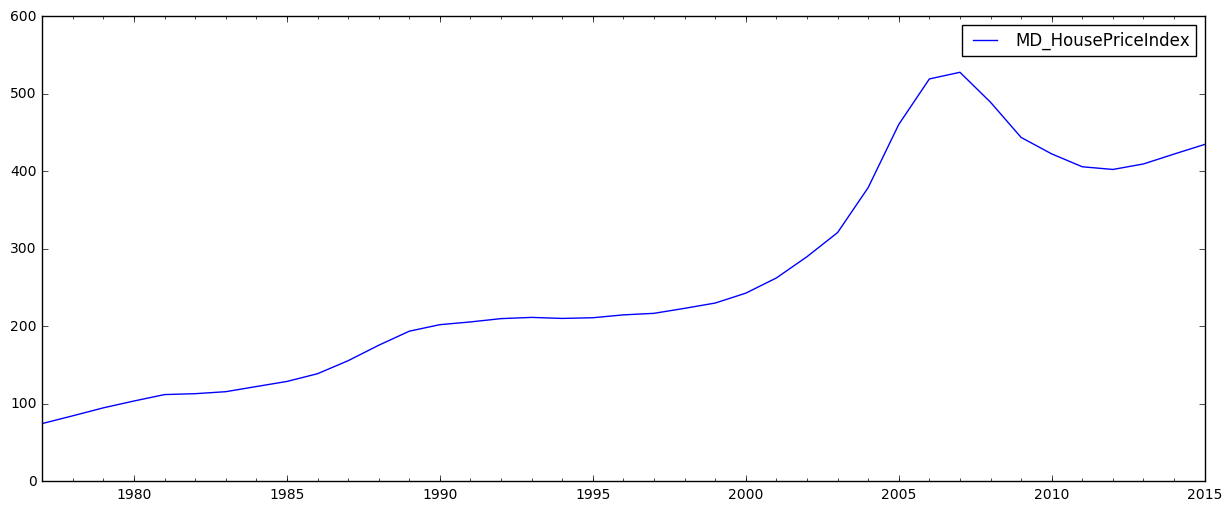

In [11]:
MD_HPI.plot(figsize=(15,6))
plt.show()

There is an overall increasing trend in the data.After 2007, we can see dip which is obvious because of crisis.

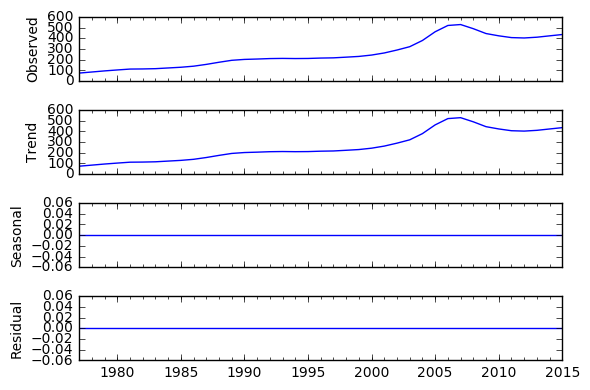

In [12]:
#Decomposing into  trend, seasonal and residual using additive model.
decomposition = sm.tsa.seasonal_decompose(MD_HPI, model='additive')
fig = decomposition.plot()
plt.show()
#fig.savefig('Seasonal_Decompose.png', dpi=150)

# Stationarity

We are taking two techniques to check if the dataset is stationary or not. First, check the mean and variance. Second, Dickey-Fuller test.

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [13]:
#we can split our dataset and calculate the mean and variance for each group.
def meanVarianceCheck(df):
    X = df.values
    split = len(X) / 2
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return ('mean1=%f, mean2=%f' % (mean1, mean2), 'variance1=%f, variance2=%f' % (var1, var2))

In [14]:
meanVarianceCheck(MD_HPI)

('mean1=150.876053, mean2=366.022000',
 'variance1=2296.958000, variance2=10678.699472')

In [15]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

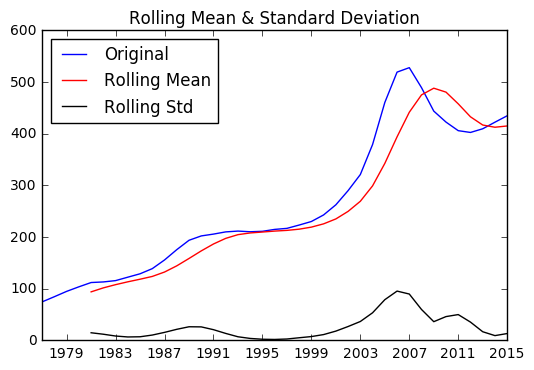

Results of Dickey-Fuller Test:
Test Statistic                  1.573077
p-value                         0.997775
#Lags Used                      9.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (10%)           -2.623158
Critical Value (5%)            -2.967882
dtype: float64


In [16]:
test_stationarity(MD_HPI.MD_HousePriceIndex)

# Estimating & Eliminating Trend

In [17]:
#log transform
def logTransform(df):
    ts_log = np.log(df)
    plt.plot(ts_log)
    return ts_log

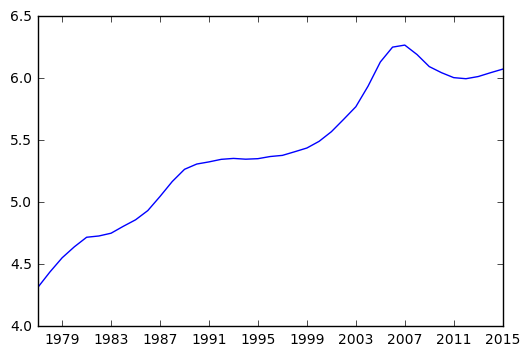

In [18]:
ts_log = logTransform(MD_HPI)

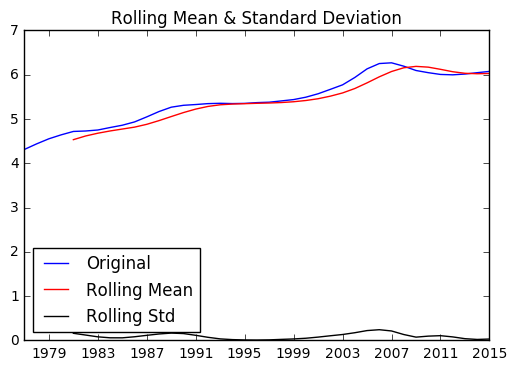

Results of Dickey-Fuller Test:
Test Statistic                 -1.481994
p-value                         0.542399
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
Critical Value (5%)            -2.945951
dtype: float64


In [19]:
test_stationarity(ts_log.MD_HousePriceIndex)

In [20]:
#Differencing - taking the differece with a particular time lag
def logFirstDifference(ts_log):
    ts_log_diff = ts_log - ts_log.shift()
    ts_log_diff.dropna(inplace=True)
    return ts_log_diff

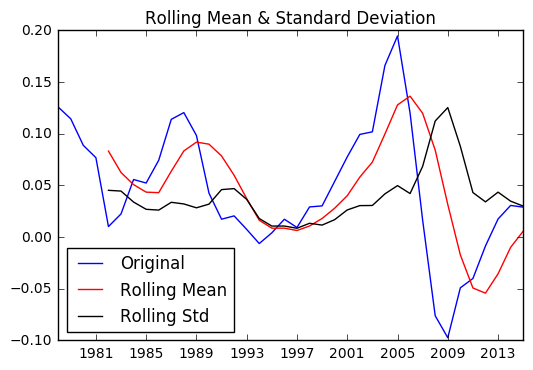

Results of Dickey-Fuller Test:
Test Statistic                 -3.811226
p-value                         0.002795
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
Critical Value (5%)            -2.945951
dtype: float64


In [21]:
ts_log_diff = logFirstDifference(ts_log)
test_stationarity(ts_log_diff.MD_HousePriceIndex)

In [22]:
def firstDifference(df):
    ts_first_diff = df - df.shift()
    ts_first_diff.dropna(inplace=True)
    return ts_first_diff

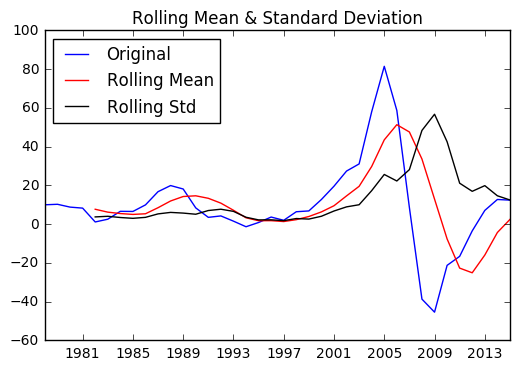

Results of Dickey-Fuller Test:
Test Statistic                 -2.651445
p-value                         0.082824
#Lags Used                      2.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (10%)           -2.613017
Critical Value (5%)            -2.948510
dtype: float64


In [23]:
ts_first_diff = firstDifference(MD_HPI)
test_stationarity(ts_first_diff.MD_HousePriceIndex)

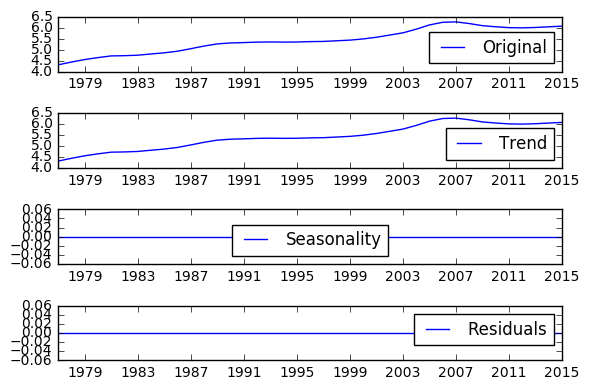

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

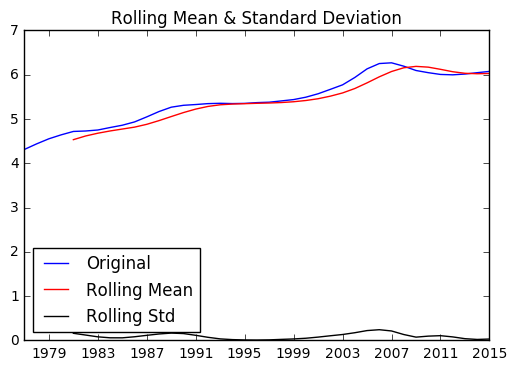

Results of Dickey-Fuller Test:
Test Statistic                 -1.481994
p-value                         0.542399
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (10%)           -2.611671
Critical Value (5%)            -2.945951
dtype: float64


In [25]:
ts_log_decompose = trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose.MD_HousePriceIndex)

In [26]:
lag_acf = acf(ts_log, nlags=10)
lag_pacf = pacf(ts_log, nlags=10, method='ols')

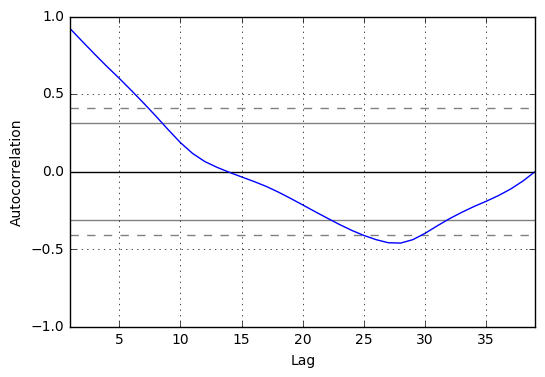

In [27]:
autocorrelation_plot(ts_log)
plt.show()

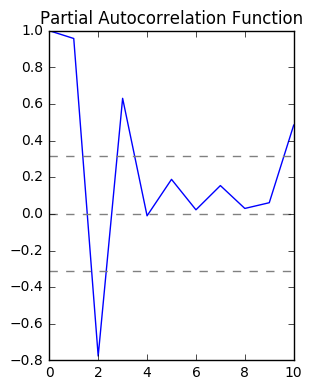

In [28]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [29]:
aic_metric = pd.DataFrame({'Modelname':[],'AIC':[]})
aic_dict = {} 

In [30]:
def cal_aic_metric(modelname,model):
    global aic_metric
    AIC = model.aic
    aic_dict[modelname] = AIC
    df_error = pd.DataFrame({'Modelname':[modelname],'AIC':[AIC]})
    aic_metric = pd.concat([aic_metric,df_error])
    return aic_metric

In [31]:
def AR_Model(ts):
    model = ARIMA(ts, order=(2, 0, 0))
    results_AR = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 0))',results_AR)
    print('Lag: %s' % results_AR.k_ar)
    print('Coefficients: %s' % results_AR.params)
    print(results_AR.summary())
    plt.plot(ts_log)
    plt.plot(results_AR.fittedvalues, color='red')
    return results_AR

Lag: 2
Coefficients: const                       5.153608
ar.L1.MD_HousePriceIndex    1.885314
ar.L2.MD_HousePriceIndex   -0.892812
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     MD_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 0)   Log Likelihood                  70.668
Method:                       css-mle   S.D. of innovations              0.036
Date:                Thu, 27 Apr 2017   AIC                           -133.336
Time:                        16:49:25   BIC                           -126.682
Sample:                    01-01-1977   HQIC                          -130.949
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.1536

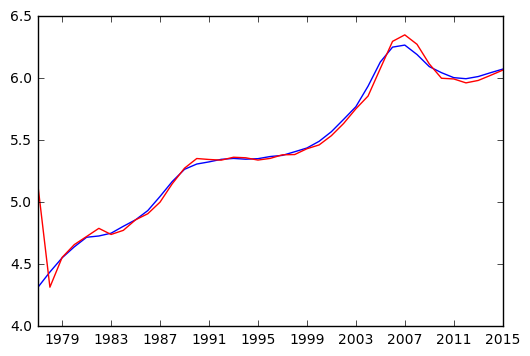

In [32]:
model_AR = AR_Model(ts_log)

In [33]:
def MA_Model(ts):
    model = ARIMA(ts_log, order=(0,0, 1))  
    results_MA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(0, 0, 1))',results_MA)
    print('Lag: %s' % results_MA.k_ar)
    print('Coefficients: %s' % results_MA.params)
    print(results_MA.summary())
    plt.plot(ts_log)
    plt.plot(results_MA.fittedvalues, color='red')
    return results_MA

Lag: 0
Coefficients: const                       5.415186
ma.L1.MD_HousePriceIndex    0.999934
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     MD_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(0, 1)   Log Likelihood                  -8.394
Method:                       css-mle   S.D. of innovations              0.286
Date:                Thu, 27 Apr 2017   AIC                             22.788
Time:                        16:49:29   BIC                             27.779
Sample:                    01-01-1977   HQIC                            24.578
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.4152      0.091     59.830      0.000    

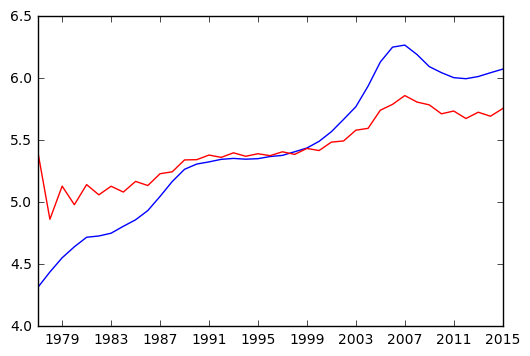

In [34]:
model_MA = MA_Model(ts_log)

In [35]:
def Combined_Model(ts):
    model = ARIMA(ts_log, order=(2, 0, 1))  
    results_ARIMA = model.fit(disp=0)
    cal_aic_metric('ARIMA(ts, order=(2, 0, 1))',results_ARIMA)
    print('Lag: %s' % results_ARIMA.k_ar)
    print('Coefficients: %s' % results_ARIMA.params)
    print(results_ARIMA.summary())
    plt.plot(ts_log)
    plt.plot(results_ARIMA.fittedvalues, color='red')
    return results_ARIMA

Lag: 2
Coefficients: const                       5.181727
ar.L1.MD_HousePriceIndex    1.805388
ar.L2.MD_HousePriceIndex   -0.813741
ma.L1.MD_HousePriceIndex    0.633535
dtype: float64
                              ARMA Model Results                              
Dep. Variable:     MD_HousePriceIndex   No. Observations:                   39
Model:                     ARMA(2, 1)   Log Likelihood                  78.097
Method:                       css-mle   S.D. of innovations              0.029
Date:                Thu, 27 Apr 2017   AIC                           -146.193
Time:                        16:49:32   BIC                           -137.875
Sample:                    01-01-1977   HQIC                          -143.209
                         - 01-01-2015                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

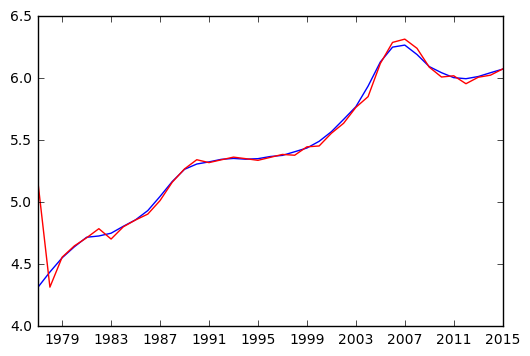

In [36]:
model_Combined = Combined_Model(ts_log)

In [37]:
aic_metric

,AIC,Modelname
0,-133.336319,"ARIMA(ts, order=(2, 0, 0))"
0,22.787852,"ARIMA(ts, order=(0, 0, 1))"
0,-146.193191,"ARIMA(ts, order=(2, 0, 1))"


In [38]:
aic_dict

{'ARIMA(ts, order=(0, 0, 1))': 22.78785221981468,
 'ARIMA(ts, order=(2, 0, 0))': -133.33631927862822,
 'ARIMA(ts, order=(2, 0, 1))': -146.19319119880632}

In [39]:
#### Calculate best model
best_model =  min(aic_dict.items(),key=operator.itemgetter(1))[0]
print('Best Model is ', best_model)

Best Model is  ARIMA(ts, order=(2, 0, 1))


In [40]:
#Forcast using Best Model
def forecast(model,numSteps):
    #model.forecast(steps=numSteps)
    output = model.forecast(steps=numSteps)[0]
    output.tolist()
    output = np.exp(output)
    print(output)
    return output

In [41]:
output_forecast = forecast(model_AR,5)

[ 443.1914103   447.597281    448.36169582  445.85128883  440.4849786 ]
